# Introduction to Data Science - Assignment 5
---

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from seaborn import heatmap, diverging_palette
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

In [87]:
def percentplot(data, x, hue):
    filtered = data.groupby(x)[hue].value_counts(normalize=True)
    filtered = filtered.mul(100).rename('percent').reset_index()
    sea.catplot(
        data = filtered,
        x = x,
        y = 'percent',
        hue = hue,
        kind = 'bar',
    )
    plt.show()

# Data Schema

In [88]:
data = pd.read_csv('./football.csv')


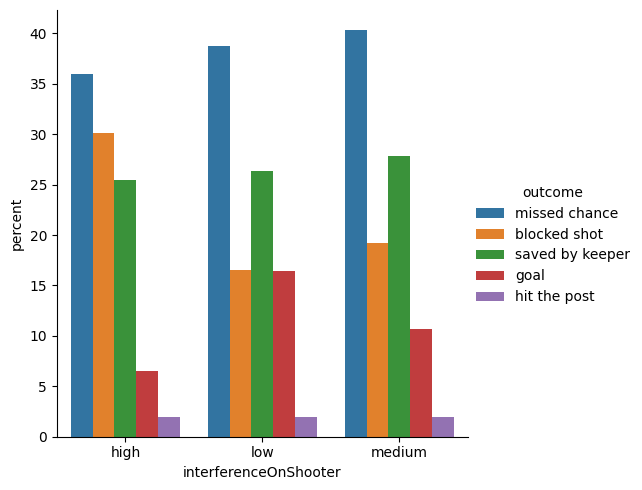

In [89]:
percentplot(
    data = data,
    x = 'interferenceOnShooter',
    hue = 'outcome'
)


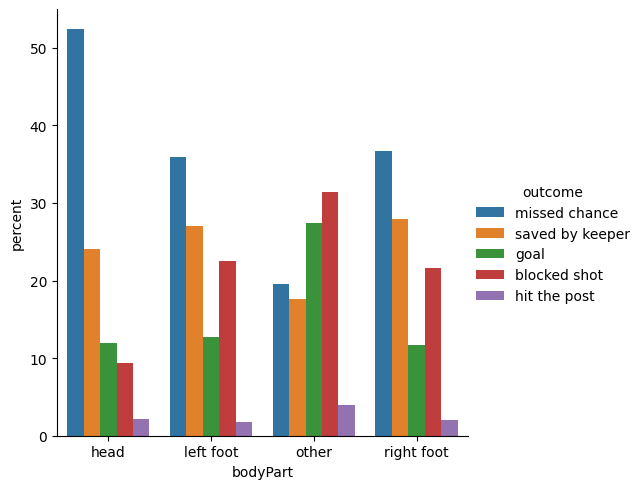

In [90]:
percentplot(
    data = data,
    x = 'bodyPart',
    hue = 'outcome'
)

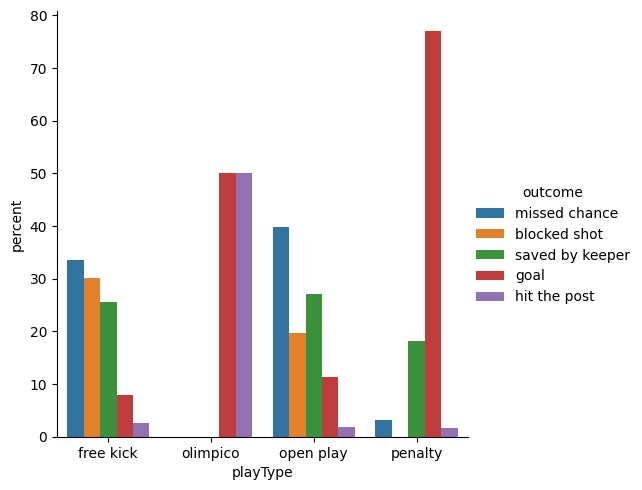

In [91]:
percentplot(
    data = data,
    x = 'playType',
    hue = 'outcome'
)

In [92]:
data = data.drop(columns=['matchId', 'playerId'])

# Feature Preprocess

## Missing Values

<a id='missing'></a>

In [93]:
def missing_report(data):
    nan_values = pd.DataFrame()
    nan_values['missing_count'] = data.isna().sum()
    nan_values['missing_percentage'] = nan_values['missing_count'] / data.shape[0]

    return nan_values.round(4)

def fill_missings(data: pd.DataFrame):
    numeric = data.select_dtypes(include=['number']).columns
    data[numeric] = data[numeric].fillna(data[numeric].mean())

    categorical = data.select_dtypes(include=['category', 'object']).columns
    data[categorical] = data[categorical].fillna(data[categorical].mode().iloc[0])

In [94]:
missing_report(data)

,missing_count,missing_percentage
playType,0,0.00
bodyPart,0,0.00
x,0,0.00
y,0,0.00
interveningOpponents,0,0.00
interveningTeammates,0,0.00
interferenceOnShooter,34,0.00
minute,0,0.00
second,0,0.00
outcome,34,0.00


In [95]:
data.dropna(inplace=True)
missing_report(data)

,missing_count,missing_percentage
playType,0,0.00
bodyPart,0,0.00
x,0,0.00
y,0,0.00
interveningOpponents,0,0.00
interveningTeammates,0,0.00
interferenceOnShooter,0,0.00
minute,0,0.00
second,0,0.00
outcome,0,0.00


## outcome

As we want to predict whetear a shot was scored, we consider all other outcomes but goal, as missed.

In [96]:
print(data['outcome'].value_counts())
data['outcome'] = data['outcome'].replace(['hit the post', 'missed chance', 'blocked shot', 'saved by keeper'], 'missed')
print(data['outcome'].value_counts())

outcome
missed chance      3470
saved by keeper    2395
blocked shot       1771
goal               1081
hit the post        174
Name: count, dtype: int64
outcome
missed    7810
goal      1081
Name: count, dtype: int64


In [97]:
raw_data = data.copy(deep=True)

## playType

In [98]:
data['playType'].value_counts()
data['playType'] = data['playType'].replace('olimpico', 'free kick')
data['playType'].value_counts()

playType
open play    8344
free kick     421
penalty       126
Name: count, dtype: int64

## bodyPart

Since it doesn't matter with which foot the shot was made, we can make them same.

In [99]:
data['bodyPart'].value_counts()
data['bodyPart'] = data['bodyPart'].replace(['right foot', 'left foot'], 'foot')
data['bodyPart'].value_counts()

bodyPart
foot     7332
head     1508
other      51
Name: count, dtype: int64

## interferenceOnShooter

In [100]:
data['interferenceOnShooter'].value_counts()

interferenceOnShooter
medium    4186
low       3315
high      1390
Name: count, dtype: int64

## time

In [101]:
data = data.drop(columns=['second'], axis = 1)

lastMinutes
False    5574
True     3317
Name: count, dtype: int64


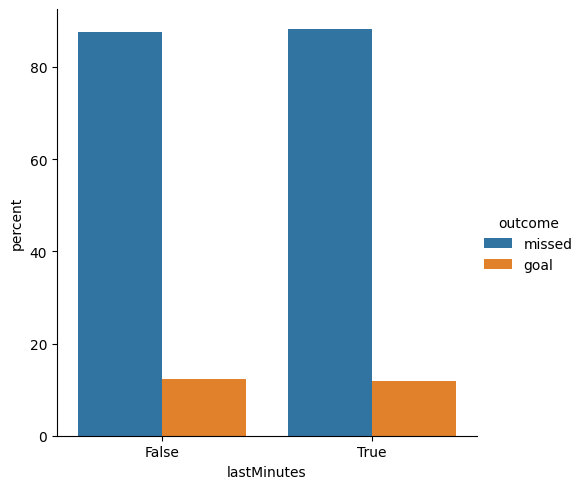

In [102]:
data['lastMinutes'] = (data['minute'] >= 60)
print(data['lastMinutes'].value_counts())
percentplot(data, 'lastMinutes', hue='outcome')

In [103]:
data = data.drop(columns=['lastMinutes', 'minute'], axis = 1)

## Feature Engineering 

In [104]:
def distance(x, y):
    return np.sqrt(x ** 2 + y ** 2)

def angle(x, y):
    tetha = (7.32 * x) / (x ** 2 + y ** 2 - (7.32 / 2) ** 2)
    if tetha >= 0:
        return np.rad2deg(np.arctan(tetha))
    else:
        return np.rad2deg(np.arctan(tetha) + np.pi)

## Train a Model

In [105]:
data.select_dtypes(include=['object']).columns

Index(['playType', 'bodyPart', 'interferenceOnShooter', 'outcome'], dtype='object')

In [106]:
data = pd.get_dummies(data, columns=['playType', 'bodyPart', 'interferenceOnShooter'])

In [107]:
data

,x,y,interveningOpponents,interveningTeammates,outcome,playType_free kick,playType_open play,playType_penalty,bodyPart_foot,bodyPart_head,bodyPart_other,interferenceOnShooter_high,interferenceOnShooter_low,interferenceOnShooter_medium
0,13.47,-11.22,1,0,goal,False,True,False,True,False,False,False,False,True
1,9.48,14.22,3,0,missed,False,True,False,True,False,False,False,False,True
2,29.43,-1.25,6,2,missed,True,False,False,True,False,False,False,True,False
3,26.93,1.00,4,1,missed,False,True,False,True,False,False,False,False,True
4,10.72,5.24,2,0,goal,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8920,6.48,3.99,3,0,missed,False,True,False,False,True,False,True,False,False
8921,21.45,-8.73,4,1,missed,False,True,False,True,False,False,False,False,True
8922,11.97,3.24,3,0,missed,False,True,False,True,False,False,False,False,True
8923,6.48,-6.98,1,0,missed,False,True,False,True,False,False,True,False,False


In [108]:
def encode_label(data):
    label_encoder = LabelEncoder()
    for column in data.columns:
        if data[column].dtype == 'object':
            data[column] = label_encoder.fit_transform(data[column])

    return data

def train_models(data):
    X = data.drop(columns=['outcome'], axis = 1)
    Y = data['outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state = 41)
    clf = LazyClassifier(verbose=-1, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    
    return models.sort_values(by = 'ROC AUC', ascending=False)

In [109]:
train_models(encode_label(raw_data.copy(deep=True)))

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:08<00:00,  3.43it/s]

[LightGBM] [Info] Number of positive: 7019, number of negative: 982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 8001, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.877265 -> initscore=1.966785
[LightGBM] [Info] Start training from score 1.966785


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.58,0.66,0.66,0.66,0.01
GaussianNB,0.86,0.61,0.61,0.85,0.01
LabelPropagation,0.83,0.58,0.58,0.83,1.99
ExtraTreeClassifier,0.83,0.58,0.58,0.83,0.02
PassiveAggressiveClassifier,0.82,0.58,0.58,0.82,0.02
BaggingClassifier,0.86,0.58,0.58,0.85,0.17
XGBClassifier,0.88,0.57,0.57,0.86,0.08
ExtraTreesClassifier,0.89,0.57,0.57,0.86,0.46
LabelSpreading,0.83,0.57,0.57,0.83,3.04


In [110]:
train_models(encode_label(data.copy(deep=True)))

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:07<00:00,  3.72it/s]

[LightGBM] [Info] Number of positive: 7019, number of negative: 982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 8001, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.877265 -> initscore=1.966785
[LightGBM] [Info] Start training from score 1.966785


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.72,0.67,0.67,0.77,0.01
NearestCentroid,0.59,0.65,0.65,0.66,0.01
KNeighborsClassifier,0.88,0.58,0.58,0.86,0.04
ExtraTreeClassifier,0.83,0.58,0.58,0.83,0.01
LabelPropagation,0.89,0.57,0.57,0.86,1.70
RandomForestClassifier,0.87,0.57,0.57,0.85,0.52
ExtraTreesClassifier,0.86,0.57,0.57,0.84,0.38
GaussianNB,0.85,0.57,0.57,0.84,0.01
LabelSpreading,0.89,0.57,0.57,0.86,2.82


We can see that the before preprocessing, we reached an ROC AUC score of 0.68 with `NearestCentroid` model but it has a low Accuracy and F1 Score. 

After preprocess, we reached ROC AUC score of 0.71 with `BernoulliNB` which was 0.50 before preprocess. Also it has high Accuracy and F1 Score.

The `BernoulliNB` model might be performing well on the data for several reasons:

1. **Binary Features**: `BernoulliNB` is designed for binary/boolean features. We made many features of the data into binary in the preprocess.

2. **Independence Assumption**: `BernoulliNB` assumes that all features are independent given the class. While this assumption is not always true in our footbal data, it can often work well in practice.

3. **Prior Probabilities**: `BernoulliNB` incorporates prior probabilities of each class. If these priors accurately represent the distribution of classes in our data, this could improve performance.

4. **Robustness to Irrelevant Features**: Naive Bayes classifiers like `BernoulliNB` are known to be robust to irrelevant features.

5. **Parameter Estimation**: `BernoulliNB` uses Maximum Likelihood Estimation (MLE) to estimate parameters, which can be effective if the MLE assumptions hold for the data.

## Feature Importance

In `BernoulliNB` we can get the importance of each feature by using the `feature_log_prob_` attribute. This attribute returns the empirical log probability of features given a class: $$P(x_i|y)$$

The log probabilities are negative, and closer to zero means higher probability. So, the features with log probabilities closer to zero are more important.

Note that these are not “importance” scores in the same sense as feature importances from tree-based models. They are simply the log probabilities of the features given a class, and they can give us some idea of which features are more discriminative for the model.

In [111]:
def feature_importance(data, model):
    X = data.drop(columns=['outcome'], axis = 1)
    Y = data['outcome']
    
    model.fit(X, Y)
    importances = model.feature_log_prob_[1]
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

    return feature_importances.sort_values('importance', ascending=False)

feature_importance(encode_label(data.copy(deep=True)), BernoulliNB())

,feature,importance
0,x,-0.00
2,interveningOpponents,-0.00
5,playType_open play,-0.05
7,bodyPart_foot,-0.19
1,y,-0.64
12,interferenceOnShooter_medium,-0.74
11,interferenceOnShooter_low,-1.04
3,interveningTeammates,-1.33
8,bodyPart_head,-1.77
10,interferenceOnShooter_high,-1.79


In [112]:
correlation = encode_label(data.copy(deep=True)).corr()['outcome'].sort_values(ascending=False)
correlation

outcome                         1.00
x                               0.22
interveningOpponents            0.21
interveningTeammates            0.10
playType_open play              0.09
interferenceOnShooter_high      0.07
interferenceOnShooter_medium    0.04
playType_free kick              0.03
bodyPart_foot                   0.00
bodyPart_head                   0.00
y                              -0.00
bodyPart_other                 -0.04
interferenceOnShooter_low      -0.10
playType_penalty               -0.24
Name: outcome, dtype: float64

## Heatmap

In [113]:
def heatmap_field(data, title):
    cent_x = 120
    cent_y = 45
    fig, ax = plt.subplots(figsize=(10, 7.5))

    # Field
    field = patches.Rectangle((0, 0), 120, 90, linewidth=2, edgecolor='black', facecolor='green')
    ax.add_patch(field)

    # Shots
    hb = ax.hexbin(cent_x - data['x'], cent_y - data['y'], gridsize=30, cmap='Reds', mincnt=1)

    # Penalty Spot
    ax.plot(cent_x - 11, cent_y - 0, 'wo', color="yellow", markersize=6, markeredgewidth=1, markeredgecolor="black")
    text = ax.text(cent_x - 8, cent_y - 5, 'Penalty Spot', ha='center', va='bottom', fontsize=8, weight='bold', color='yellow')
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

    # Penalty Area
    penalty_area = patches.Rectangle((120-16.5, 24.85), 16.5, 40.3, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(penalty_area)
    circle = patches.Arc((109, 45), 9.15 * 2, 9.15 * 2, angle=125, theta1=0, theta2=107, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(circle)

    # Center Line and Circle
    center_line = patches.Rectangle((60, 0), 0, 90, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(center_line)
    circle = patches.Circle((60, 45), 9.15, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(circle)
    ax.plot(60, 45, 'wo', color="black") 

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 90)
    ax.set_aspect('equal')

    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Shots Density')
    plt.title(title)
    plt.show()


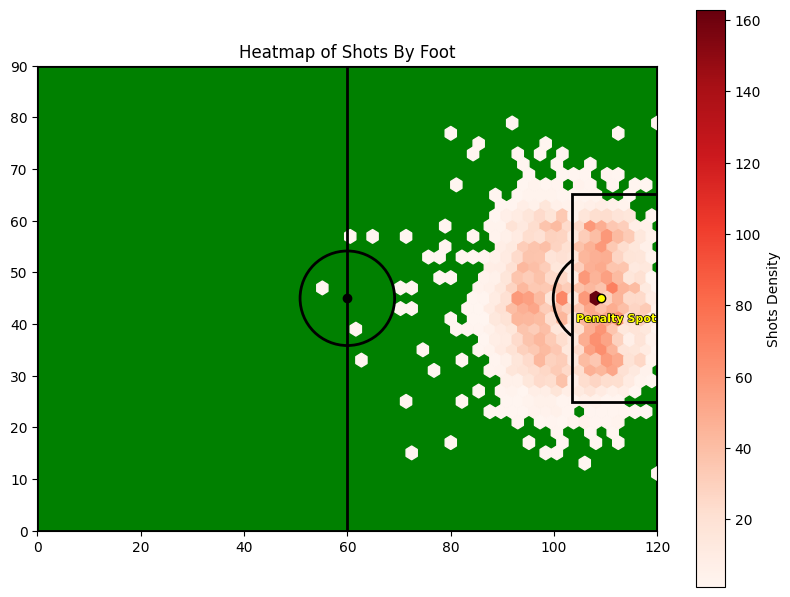

In [114]:
heatmap_field(data[data['bodyPart_foot'] == True], 'Heatmap of Shots By Foot')

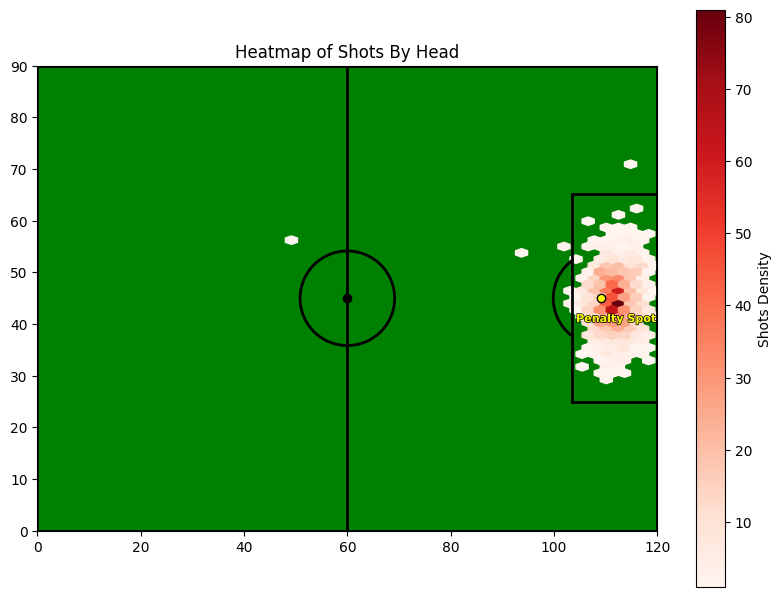

In [115]:
heatmap_field(data[data['bodyPart_head'] == True], 'Heatmap of Shots By Head')

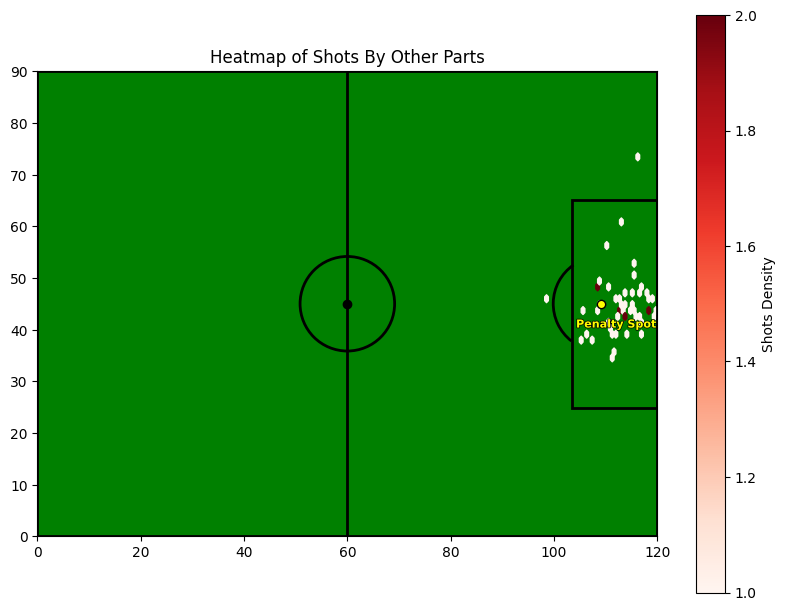

In [116]:
heatmap_field(data[data['bodyPart_other'] == True], 'Heatmap of Shots By Other Parts')

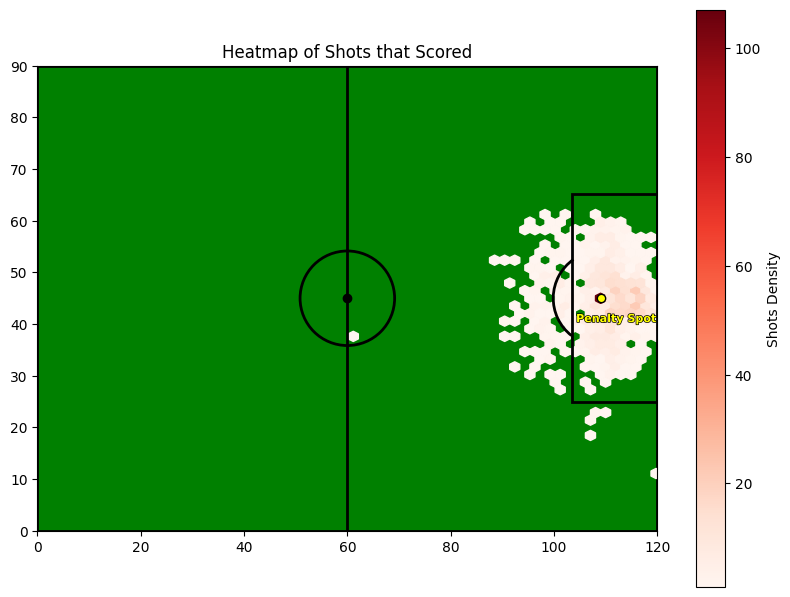

In [117]:
heatmap_field(data[data['outcome'] == 'goal'], 'Heatmap of Shots that Scored')

# Questions

#### **1. Describe your strategy for addressing challenges such as handling missing values and categorical features. Could you also elaborate on your feature selection metrics and explain the rationale behind them?**

As you can see [here](#missing), very small amount of our data is missed. We used mode imputation for `interferenceOnShooter` and `outcome` to fill them as they are categorical features.

Also for handling categorical features, we turned some of them into binary features (e.g `outcome` -> goal/missed).
For `playType`, `bodyPart`, `interferenceOnShooter`, we added binary columns to the data for each category.

We used `ROC AUC` metric to determine the outcome of the shots. This metric is often used in binary classification problems. Here are some reasons why ROC AUC is a good choice for this task:

1. **Balance Between Sensitivity and Specificity**: ROC AUC considers both the true positive rate (sensitivity) and false positive rate (1-specificity) of a model. This makes it a good metric when both false positives and false negatives are important. 

2. **Performance on Imbalanced Data**: ROC AUC can be a better metric than accuracy when dealing with imbalanced datasets, which are common in sports analytics. For example, goals are relatively rare in football matches, as we can see that in our own dataset. So predicting "missed" will often be correct, leading to high accuracy, but this isn't very informative. 

3. **Ranking of Predictions**: ROC AUC measures the ability of a model to rank predictions correctly, which can be more important than producing well-calibrated probabilities in some cases.



#### **2. Why didn’t we use regression to predict whether a shot would result in a goal?**

In the case of predicting whether a shot would result in a goal, the output is binary: either a goal is scored (1) or it isn’t (0). This is a classic example of a binary classification problem, and it’s typically more appropriate to use a classification algorithm for this type of problem.

On the other hand, regression is used when the output variable is a real or continuous value, such as predicting the number of goals a team will score in a season, the number of shots a player will take in a game, or the amount of time until the next goal is scored.

Classification algorithms like `BernoulliNB` are designed to handle binary outcomes and can provide probabilities for each class, which can be useful for understanding the confidence of the model in its predictions. They also have methods for handling class imbalance, which can be an issue in datasets where goals are relatively rare events.

#### **3. How would you go about verifying the accuracy of the given formula used to calculate the shot angle in the preprocessing section?**

To verify the accuracy of the formula employed for determining the shot angle, a comparison could be made between the angles computed using the formula and the actual angles for certain shots. Also not the fact that the distance in meters between the goal posts in soccer is **7.32**. This is why this number appears in the formula. 

A few shots could be selected for manual angle calculation using the formula, and these calculated angles could then be juxtaposed with the real angles. If there's a close match between the calculated and actual angles, it would suggest that the formula is reliable. 

Moreover, a graphical representation could be created by plotting the calculated angles against the actual ones. This would provide a visual means to evaluate the formula's accuracy. 

For a comprehensive mathematical validation, you can refer to this article: *https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760*